<a href="https://colab.research.google.com/github/RahulS77/11ty-landing-page/blob/main/7PAM2002_0509_2024_Rahul_Shah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Pollutant AQI Prediction for Los Angeles (Final Year Project)

This notebook predicts Air Quality Index (AQI) levels for PM2.5, PM10, and ozone in Los Angeles County (2014–2024) using US EPA data from GitHub. It includes data exploration, preprocessing, modeling with Random Forest, XGBoost, and ARIMA, sanity checks, and model comparison.

## Project Structure
1. **Data Loading**: Load pollutant and meteorological data from GitHub.
2. **Data Exploration**: Visualize distributions, correlations, and time trends.
3. **Data Preprocessing**: Merge datasets, calculate AQI, handle missing values, and engineer features.
4. **Model Development**: Train Random Forest, XGBoost, and ARIMA models.
5. **Sanity Checks**: Validate models for leakage, shuffling, cross-validation, and baseline comparison.
6. **Model Comparison**: Evaluate models using MSE, MAE, and R² with visualizations and a metrics table.
7. **Output**: Save processed data and models.

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
import requests
import io
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

## 2. Load Data

In [6]:
# Define GitHub base URL and file names
github_base_url = "https://raw.githubusercontent.com/RahulS77/7PAM2002-0509-2024-Final-Project-AQI/refs/heads/master/raw_data/"
data_files = {
    "pm25": "la_pm25_2014_2024.csv",
    "pm10": "la_pm10_2014_2024.csv",
    "ozone": "la_ozone_2014_2024.csv",
    "temperature": "la_temperature_2014_2024.csv",
    "wind_speed": "la_wind_speed_2014_2024.csv",
    "wind_direction": "la_wind_direction_2014_2024.csv",
    "rh": "la_rh_2014_2024.csv"
}

# Dictionary to store DataFrames
dfs = {}

# Load each CSV file from GitHub
for data_type, file_name in data_files.items():
    url = f"{github_base_url}{file_name}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        dfs[data_type] = pd.read_csv(io.StringIO(response.text))
        print(f'\nLoaded {data_type} data: {dfs[data_type].shape}')
        print(f'Columns in {data_type}: {list(dfs[data_type].columns)}')
    except requests.exceptions.RequestException as e:
        print(f'Failed to load {data_type} data from {url}: {e}')

# Display sample PM2.5 data
if 'pm25' in dfs:
    print("\nSample PM2.5 data:")
    display(dfs['pm25'].head())
else:
    print("PM2.5 data not loaded.")


Loaded pm25 data: (258894, 32)
Columns in pm25: ['state_code', 'county_code', 'site_number', 'parameter_code', 'poc', 'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code', 'sample_duration', 'pollutant_standard', 'date_local', 'units_of_measure', 'event_type', 'observation_count', 'observation_percent', 'validity_indicator', 'arithmetic_mean', 'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method', 'local_site_name', 'site_address', 'state', 'county', 'city', 'cbsa_code', 'cbsa', 'date_of_last_change']

Loaded pm10 data: (25538, 32)
Columns in pm10: ['state_code', 'county_code', 'site_number', 'parameter_code', 'poc', 'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code', 'sample_duration', 'pollutant_standard', 'date_local', 'units_of_measure', 'event_type', 'observation_count', 'observation_percent', 'validity_indicator', 'arithmetic_mean', 'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method', 'local_site_name', 'site_addr

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,6,37,2,88101,1,34.1365,-117.92391,WGS84,PM2.5 - Local Conditions,7,...,120,Andersen RAAS2.5-300 PM2.5 SEQ w/WINS - GRAVIM...,Azusa,"803 N. LOREN AVE., AZUSA",California,Los Angeles,Azusa,31080,"Los Angeles-Long Beach-Anaheim, CA",2024-05-18
1,6,37,2,88101,1,34.1365,-117.92391,WGS84,PM2.5 - Local Conditions,7,...,120,Andersen RAAS2.5-300 PM2.5 SEQ w/WINS - GRAVIM...,Azusa,"803 N. LOREN AVE., AZUSA",California,Los Angeles,Azusa,31080,"Los Angeles-Long Beach-Anaheim, CA",2024-05-18
2,6,37,2,88101,1,34.1365,-117.92391,WGS84,PM2.5 - Local Conditions,7,...,120,Andersen RAAS2.5-300 PM2.5 SEQ w/WINS - GRAVIM...,Azusa,"803 N. LOREN AVE., AZUSA",California,Los Angeles,Azusa,31080,"Los Angeles-Long Beach-Anaheim, CA",2024-05-18
3,6,37,2,88101,1,34.1365,-117.92391,WGS84,PM2.5 - Local Conditions,7,...,120,Andersen RAAS2.5-300 PM2.5 SEQ w/WINS - GRAVIM...,Azusa,"803 N. LOREN AVE., AZUSA",California,Los Angeles,Azusa,31080,"Los Angeles-Long Beach-Anaheim, CA",2024-05-18
4,6,37,2,88101,1,34.1365,-117.92391,WGS84,PM2.5 - Local Conditions,7,...,120,Andersen RAAS2.5-300 PM2.5 SEQ w/WINS - GRAVIM...,Azusa,"803 N. LOREN AVE., AZUSA",California,Los Angeles,Azusa,31080,"Los Angeles-Long Beach-Anaheim, CA",2024-05-18


## 3. Data Exploration

Visualize pollutant concentrations, AQI trends, and correlations to understand the data.

### Pollutant concentration distributions

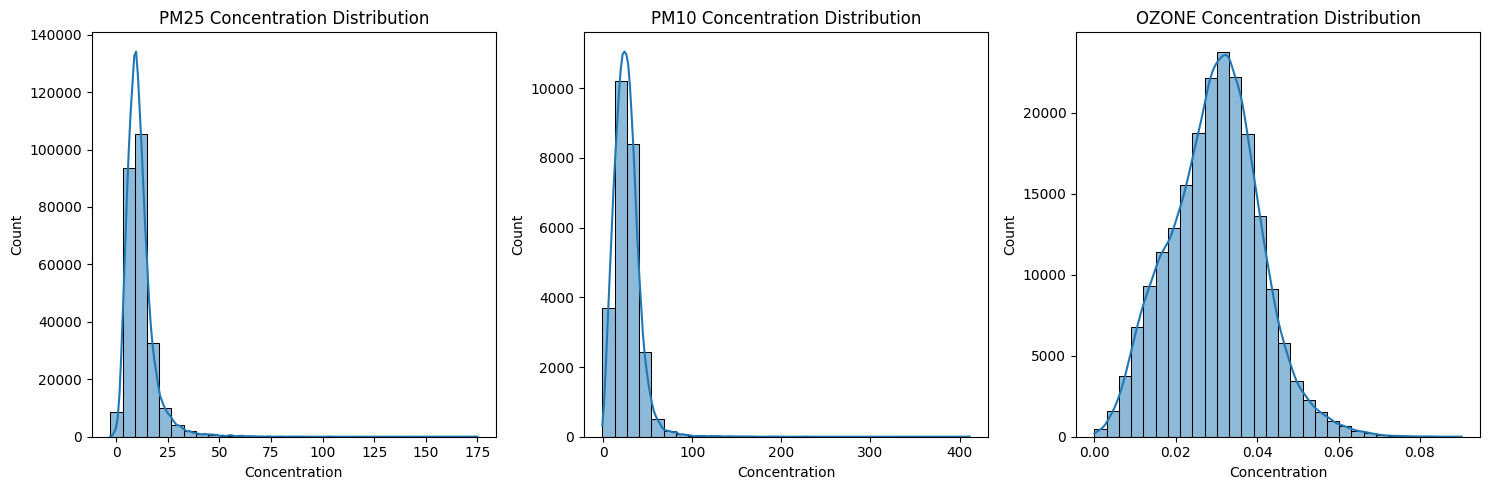

In [4]:
plt.figure(figsize=(15, 5))
for i, pollutant in enumerate(['pm25', 'pm10', 'ozone']):
    plt.subplot(1, 3, i+1)
    if pollutant in dfs:
        sns.histplot(dfs[pollutant]['arithmetic_mean'], bins=30, kde=True)
        plt.title(f'{pollutant.upper()} Concentration Distribution')
        plt.xlabel('Concentration')
        plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Time series plot for AQI

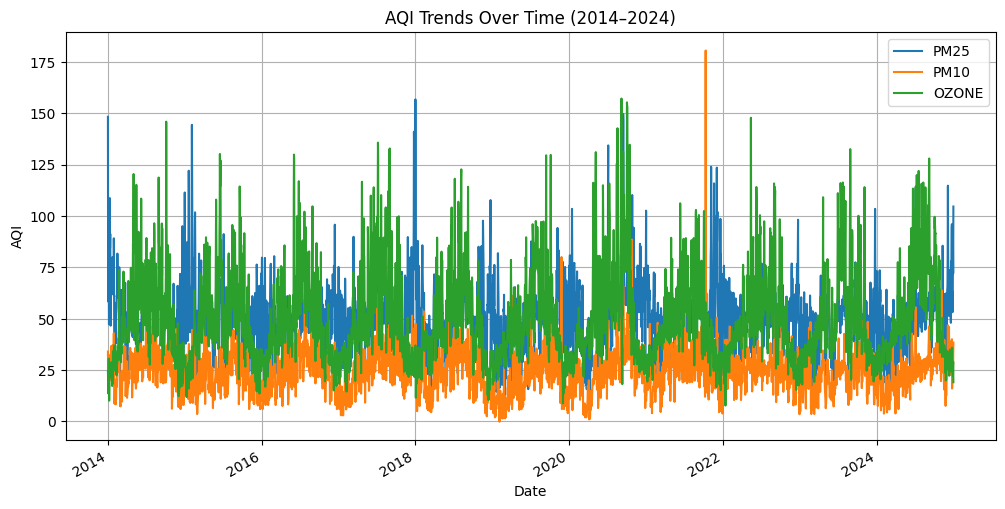

In [5]:
plt.figure(figsize=(12, 6))
for pollutant in ['pm25', 'pm10', 'ozone']:
    if pollutant in dfs:
        dfs[pollutant]['date_local'] = pd.to_datetime(dfs[pollutant]['date_local'])
        dfs[pollutant].groupby('date_local')['aqi'].mean().plot(label=pollutant.upper())
plt.title('AQI Trends Over Time (2014–2024)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

### Correlation heatmap for meteorological data

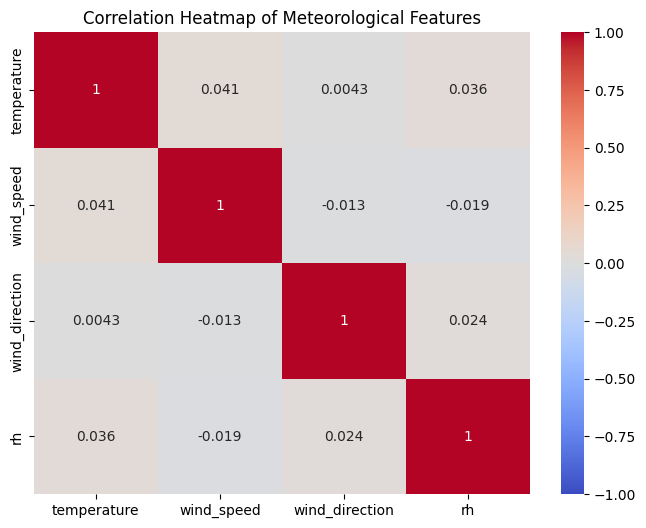

In [6]:
meteo_cols = ['temperature', 'wind_speed', 'wind_direction', 'rh']
meteo_data = pd.DataFrame()
for col in meteo_cols:
    if col in dfs:
        meteo_data[col] = dfs[col]['arithmetic_mean']
if not meteo_data.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(meteo_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of Meteorological Features')
    plt.show()

## 4. Data Preprocessing

Merge datasets, calculate AQI, handle missing values, and create features.

### AQI Calculation Function

In [7]:
def calculate_aqi(concentration, pollutant):
    if pollutant == 'pm25':
        c_low = [0.0, 12.1, 35.5, 55.5, 150.5, 250.5, 350.5]
        c_high = [12.0, 35.4, 55.4, 150.4, 250.4, 350.4, 500.4]
        aqi_low = [0, 51, 101, 151, 201, 301, 401]
        aqi_high = [50, 100, 150, 200, 300, 400, 500]
    elif pollutant == 'pm10':
        c_low = [0, 55, 155, 255, 355, 425, 505]
        c_high = [54, 154, 254, 354, 424, 504, 604]
        aqi_low = [0, 51, 101, 151, 201, 301, 401]
        aqi_high = [50, 100, 150, 200, 300, 400, 500]
    elif pollutant == 'ozone':
        c_low = [0.000, 0.055, 0.071, 0.086, 0.106, 0.201]
        c_high = [0.054, 0.070, 0.085, 0.105, 0.200, 0.404]
        aqi_low = [0, 51, 101, 151, 201, 301]
        aqi_high = [50, 100, 150, 200, 300, 500]
    else:
        return np.nan
    for i in range(len(c_low)):
        if c_low[i] <= concentration <= c_high[i]:
            aqi = ((aqi_high[i] - aqi_low[i]) / (c_high[i] - c_low[i])) * (concentration - c_low[i]) + aqi_low[i]
            return round(aqi)
    return np.nan

### Merge and preprocess data

In [8]:
# Merge and preprocess data
merged_df = pd.DataFrame()
for data_type in data_files.keys():
    if data_type in dfs:
        df = dfs[data_type].copy()  # Create a copy to avoid modifying original dfs
        # Check if required columns exist
        if 'date_local' not in df.columns or 'site_number' not in df.columns:
            print(f"Warning: Skipping {data_type} due to missing 'date_local' or 'site_number' columns.")
            continue
        # Convert date_local to datetime with error handling
        try:
            df['date_local'] = pd.to_datetime(df['date_local'], errors='coerce')
            if df['date_local'].isna().any():
                print(f"Warning: Invalid dates found in {data_type}. Dropped {df['date_local'].isna().sum()} rows with NaT.")
                df = df.dropna(subset=['date_local'])
        except Exception as e:
            print(f"Error converting date_local for {data_type}: {e}")
            continue
        # Select and rename columns
        if data_type in ['pm25', 'pm10', 'ozone']:
            if 'arithmetic_mean' not in df.columns or 'aqi' not in df.columns:
                print(f"Warning: Skipping {data_type} due to missing 'arithmetic_mean' or 'aqi' columns.")
                continue
            df = df[['date_local', 'site_number', 'arithmetic_mean', 'aqi']]
            df = df.rename(columns={'arithmetic_mean': f'{data_type}_conc', 'aqi': f'{data_type}_aqi'})
        else:
            if 'arithmetic_mean' not in df.columns:
                print(f"Warning: Skipping {data_type} due to missing 'arithmetic_mean' column.")
                continue
            df = df[['date_local', 'site_number', 'arithmetic_mean']]
            df = df.rename(columns={'arithmetic_mean': data_type})
        # Merge
        if merged_df.empty:
            merged_df = df
        else:
            try:
                merged_df = pd.merge(merged_df, df, on=['date_local', 'site_number'], how='outer')
            except Exception as e:
                print(f"Error merging {data_type}: {e}")
                continue

### Convert date_local to datetime

In [9]:
merged_df['date_local'] = pd.to_datetime(merged_df['date_local'])

### Data quality checks

In [10]:
print("\nData Quality Checks:")
for col in ['pm25_conc', 'pm10_conc', 'ozone_conc']:
    if col in merged_df.columns and merged_df[col].min() < 0:
        print(f"Warning: Negative values found in {col}. Setting to 0.")
        merged_df[col] = merged_df[col].clip(lower=0)
print(f"Unique sites: {merged_df['site_number'].nunique()}")


Data Quality Checks:
Unique sites: 20


### Recalculate AQI for missing values

In [11]:
for data_type in ['pm25', 'pm10', 'ozone']:
    aqi_col = f'{data_type}_aqi'
    conc_col = f'{data_type}_conc'
    if aqi_col in merged_df.columns and conc_col in merged_df.columns:
        merged_df[aqi_col] = merged_df.apply(
            lambda row: calculate_aqi(row[conc_col], data_type) if pd.isna(row[aqi_col]) else row[aqi_col], axis=1
        )

### Drop rows where all pollutant concentrations are missing

In [12]:
merged_df = merged_df.dropna(subset=['pm25_conc', 'pm10_conc', 'ozone_conc'], how='all')

### Feature engineering

In [13]:
merged_df['year'] = merged_df['date_local'].dt.year
merged_df['month'] = merged_df['date_local'].dt.month
merged_df['day_of_week'] = merged_df['date_local'].dt.dayofweek
for data_type in ['pm25', 'pm10', 'ozone']:
    merged_df[f'{data_type}_aqi_lag1'] = merged_df.groupby('site_number')[f'{data_type}_aqi'].shift(1)
    merged_df[f'{data_type}_conc_roll7'] = merged_df.groupby('site_number')[f'{data_type}_conc'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)

### Drop rows with missing features

In [14]:
merged_df = merged_df.dropna()

### Aggregate by date to simplify modeling

In [15]:
merged_df = merged_df.groupby('date_local').mean().reset_index()
print(f"After aggregation, number of rows: {len(merged_df)}")

After aggregation, number of rows: 1208


### Optimize data types

In [16]:
for col in merged_df.select_dtypes(include=['float64']).columns:
    merged_df[col] = merged_df[col].astype('float32')
for col in merged_df.select_dtypes(include=['int64']).columns:
    merged_df[col] = merged_df[col].astype('int32')

### Display preprocessed data

In [17]:
print("\nMerged DataFrame Info:")
print(merged_df.info())
display(merged_df.head())


Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date_local        1208 non-null   datetime64[ns]
 1   site_number       1208 non-null   float32       
 2   pm25_conc         1208 non-null   float32       
 3   pm25_aqi          1208 non-null   float32       
 4   pm10_conc         1208 non-null   float32       
 5   pm10_aqi          1208 non-null   float32       
 6   ozone_conc        1208 non-null   float32       
 7   ozone_aqi         1208 non-null   float32       
 8   temperature       1208 non-null   float32       
 9   wind_speed        1208 non-null   float32       
 10  wind_direction    1208 non-null   float32       
 11  rh                1208 non-null   float32       
 12  year              1208 non-null   float32       
 13  month             1208 non-null   float32       
 14  

,date_local,site_number,pm25_conc,pm25_aqi,pm10_conc,pm10_aqi,ozone_conc,ozone_aqi,temperature,wind_speed,...,rh,year,month,day_of_week,pm25_aqi_lag1,pm25_conc_roll7,pm10_aqi_lag1,pm10_conc_roll7,ozone_aqi_lag1,ozone_conc_roll7
0,2014-01-05,1103.0,16.453968,64.507935,36.0,33.0,0.016119,26.428572,60.762501,3.858333,...,36.875000,2014.0,1.0,6.0,64.492065,17.137642,33.0,36.0,26.190475,0.016035
1,2014-01-11,1103.0,25.757143,82.015877,40.0,37.0,0.012350,20.142857,59.766666,3.520833,...,61.166668,2014.0,1.0,5.0,81.984123,26.081633,37.0,40.0,19.952381,0.012228
2,2014-01-17,1103.0,13.500000,59.000000,41.0,38.0,0.012835,23.190475,67.633331,4.729167,...,17.458332,2014.0,1.0,4.0,59.000000,13.465986,38.0,41.0,22.936508,0.012656
3,2014-01-23,1103.0,27.906349,86.015877,49.0,45.0,0.010737,14.571428,59.275002,2.791667,...,62.625000,2014.0,1.0,3.0,85.984123,27.681179,45.0,49.0,14.476191,0.010628
4,2014-01-29,1103.0,37.752380,106.507935,61.0,54.0,0.010645,13.857142,63.038891,3.066667,...,66.277779,2014.0,1.0,2.0,106.492065,37.411564,54.0,61.0,13.714286,0.010549


## 5. Model Development

Train Random Forest, XGBoost, and ARIMA models to predict AQI for PM2.5, PM10, and ozone.

### Features and targets

In [18]:
features = ['pm25_conc', 'pm10_conc', 'ozone_conc', 'temperature', 'wind_speed', 'wind_direction', 'rh',
            'year', 'month', 'day_of_week', 'pm25_aqi_lag1', 'pm10_aqi_lag1', 'ozone_aqi_lag1',
            'pm25_conc_roll7', 'pm10_conc_roll7', 'ozone_conc_roll7']
targets = ['pm25_aqi', 'pm10_aqi', 'ozone_aqi']

### Verify features and targets

In [19]:
features = [f for f in features if f in merged_df.columns]
targets = [t for t in targets if t in merged_df.columns]
if not features or not targets:
    raise ValueError("Required features or targets missing in merged DataFrame.")

### Split data for Random Forest and XGBoost

In [20]:
X = merged_df[features]
y = merged_df[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)  # Time-based split
print(f"Tree-based model data: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

Tree-based model data: X_train shape: (966, 16), y_train shape: (966, 3)


### 5.1 Random Forest Regressor (Multi-Output)

In [21]:
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

#### Predict and evaluate

In [22]:
y_pred_rf = rf_model.predict(X_test)
rf_metrics = {}
for i, pollutant in enumerate(targets):
    mse = mean_squared_error(y_test[pollutant], y_pred_rf[:, i])
    mae = mean_absolute_error(y_test[pollutant], y_pred_rf[:, i])
    r2 = r2_score(y_test[pollutant], y_pred_rf[:, i])
    rf_metrics[pollutant] = {'MSE': mse, 'MAE': mae, 'R²': r2}
    print(f"Random Forest - {pollutant}: MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


Random Forest - pm25_aqi: MSE: 0.06, MAE: 0.14, R²: 1.00
Random Forest - pm10_aqi: MSE: 0.02, MAE: 0.08, R²: 1.00
Random Forest - ozone_aqi: MSE: 0.04, MAE: 0.12, R²: 1.00


#### Feature importance

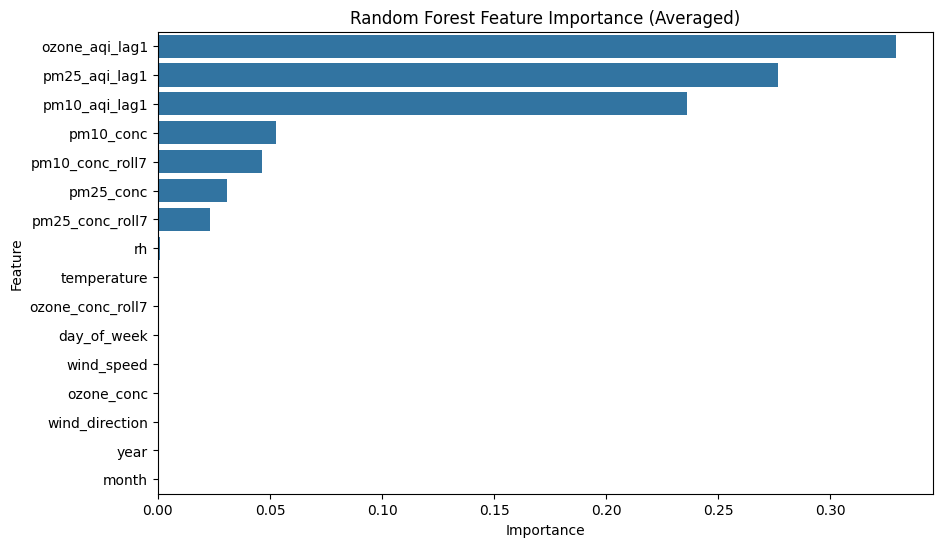

In [23]:
importances = np.mean([est.feature_importances_ for est in rf_model.estimators_], axis=0)
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importance (Averaged)')
plt.show()

### 5.2 XGBoost Regressor (Multi-Output)

In [24]:
xgb_model = MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42))
xgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))

#### Predict and evaluate

In [25]:
y_pred_xgb = xgb_model.predict(X_test)
xgb_metrics = {}
for i, pollutant in enumerate(targets):
    mse = mean_squared_error(y_test[pollutant], y_pred_xgb[:, i])
    mae = mean_absolute_error(y_test[pollutant], y_pred_xgb[:, i])
    r2 = r2_score(y_test[pollutant], y_pred_xgb[:, i])
    xgb_metrics[pollutant] = {'MSE': mse, 'MAE': mae, 'R²': r2}
    print(f"XGBoost - {pollutant}: MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

XGBoost - pm25_aqi: MSE: 0.15, MAE: 0.24, R²: 1.00
XGBoost - pm10_aqi: MSE: 0.06, MAE: 0.16, R²: 1.00
XGBoost - ozone_aqi: MSE: 0.06, MAE: 0.17, R²: 1.00


### 5.3 ARIMA

#### Prepare data for ARIMA

In [26]:
data = merged_df.copy()
data.set_index('date_local', inplace=True)

#### Scale exogenous variables (meteorological only)

In [27]:
scaler_exog = MinMaxScaler()
exog_vars = ['temperature', 'wind_speed', 'wind_direction', 'rh']
exog = data[exog_vars] if all(var in data.columns for var in exog_vars) else None
if exog is not None:
    exog_scaled = pd.DataFrame(scaler_exog.fit_transform(exog), columns=exog_vars, index=data.index)
    exog_scaled = exog_scaled.clip(0, 1)
else:
    exog_scaled = None

#### Function to fit and evaluate

In [28]:
arima_metrics = {}
y_pred_arima = {}
def fit_evaluate_arima(target_col, exog=None, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    train_size = int(len(data) * 0.8)
    train, test = data[target_col][:train_size], data[target_col][train_size:]
    exog_train, exog_test = (exog_scaled[:train_size], exog_scaled[train_size:]) if exog_scaled is not None else (None, None)

    if exog_scaled is not None:
        model = SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order)
    else:
        model = ARIMA(train, order=order)
    try:
        model_fit = model.fit()
        print(f"{target_col} Model Summary:\n", model_fit.summary())

        forecast = model_fit.forecast(steps=len(test), exog=exog_test)

        mse = mean_squared_error(test, forecast)
        mae = mean_absolute_error(test, forecast)
        r2 = r2_score(test, forecast)
        print(f"{target_col} - MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
        arima_metrics[target] = {'MSE': mse, 'MAE': mae, 'R²': r2}
        y_pred_arima[target] = forecast

        plt.figure(figsize=(10, 6))
        # plt.plot(train.index, train, label='Training Data')
        plt.plot(test.index, test, label='Actual Test Data')
        plt.plot(test.index, forecast, label='Predicted', linestyle='--')
        plt.title(f'SARIMAX Forecast vs Actual for {target_col}')
        plt.xlabel('Date')
        plt.ylabel('AQI')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return model_fit, forecast
    except Exception as e:
        print(f"Error fitting {target_col}: {e}")
        return None, None

#### Fit models

pm25_aqi Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                           pm25_aqi   No. Observations:                  966
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3795.184
Date:                            Wed, 27 Aug 2025   AIC                           7608.368
Time:                                    12:24:52   BIC                           7652.104
Sample:                                         0   HQIC                          7625.029
                                            - 966                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
temperature       20.8384      4.460      4.672      0.000      12.097      29.58

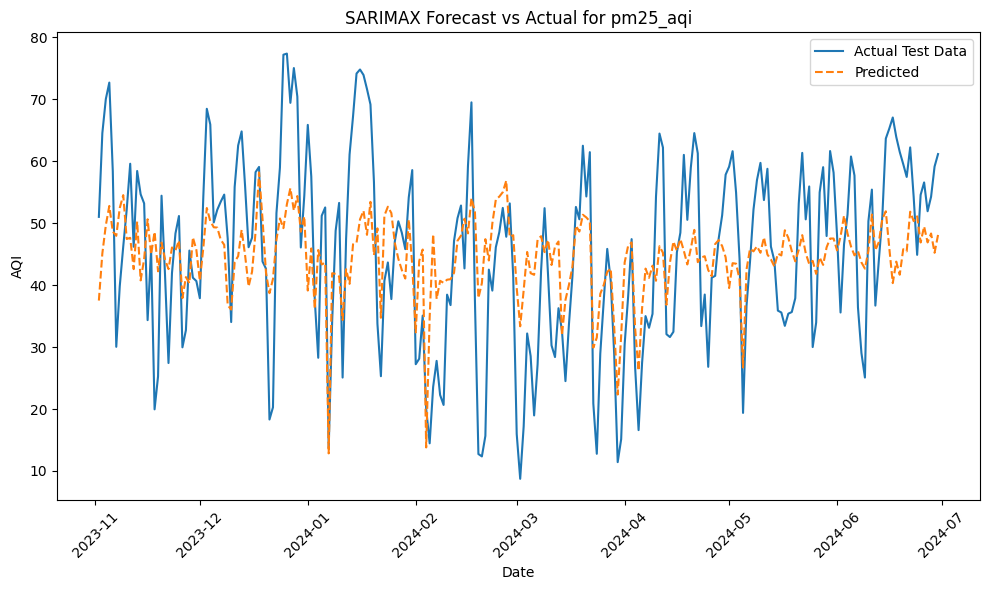

pm10_aqi Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                           pm10_aqi   No. Observations:                  966
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3308.921
Date:                            Wed, 27 Aug 2025   AIC                           6635.842
Time:                                    12:25:10   BIC                           6679.579
Sample:                                         0   HQIC                          6652.504
                                            - 966                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
temperature       24.2992      2.483      9.786      0.000      19.432      29.16

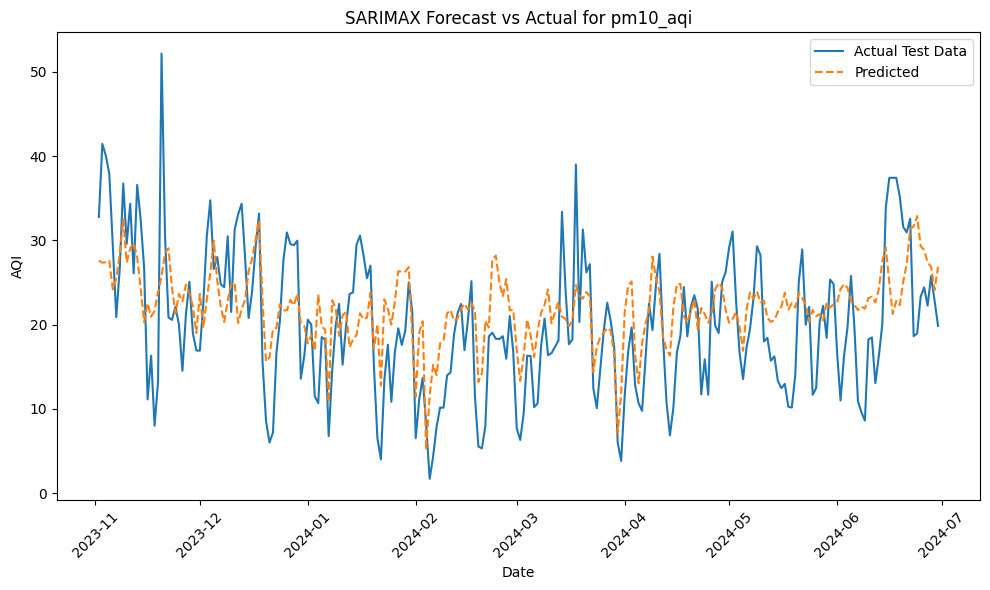

ozone_aqi Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                          ozone_aqi   No. Observations:                  966
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3832.834
Date:                            Wed, 27 Aug 2025   AIC                           7683.668
Time:                                    12:25:27   BIC                           7727.404
Sample:                                         0   HQIC                          7700.330
                                            - 966                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
temperature       74.1307      4.072     18.204      0.000      66.149      82.1

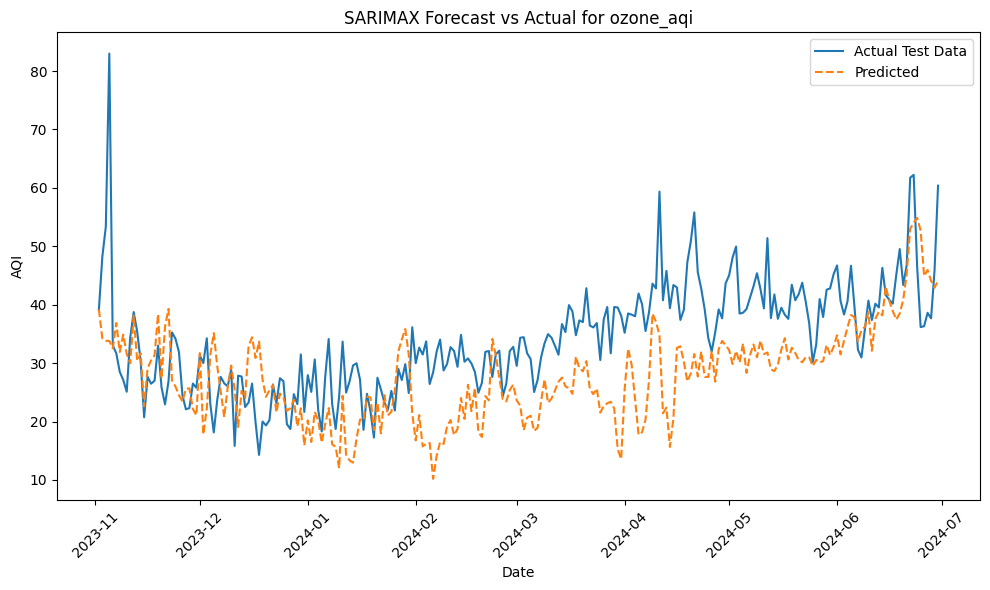

In [29]:
targets = ['pm25_aqi', 'pm10_aqi', 'ozone_aqi']
models = {}
forecasts = {}
for target in targets:
    model, forecast = fit_evaluate_arima(target, exog=exog_scaled, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    models[target] = model
    forecasts[target] = forecast

## 6. Sanity Checks

Validate model robustness with leakage checks, shuffle tests, cross-validation, baseline comparison, and residual analysis.

### Feature Leakage Check

In [30]:
leakage_check = [f for f in features if any(p in f for p in ['pm25_conc', 'pm10_conc', 'ozone_conc'])]
print(f"\nPotential leakage features: {leakage_check}")
safe_features = [f for f in features if not any(p in f for p in ['pm25_conc', 'pm10_conc', 'ozone_conc'])]
print(f"Safe features: {safe_features}")


Potential leakage features: ['pm25_conc', 'pm10_conc', 'ozone_conc', 'pm25_conc_roll7', 'pm10_conc_roll7', 'ozone_conc_roll7']
Safe features: ['temperature', 'wind_speed', 'wind_direction', 'rh', 'year', 'month', 'day_of_week', 'pm25_aqi_lag1', 'pm10_aqi_lag1', 'ozone_aqi_lag1']


### Retrain Random Forest with safe features

In [31]:
X_safe = merged_df[safe_features]
y_safe = merged_df[targets]
X_train_safe, X_test_safe, y_train_safe, y_test_safe = train_test_split(X_safe, y_safe, test_size=0.2, random_state=42, shuffle=False)
rf_model_safe = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf_model_safe.fit(X_train_safe, y_train_safe)
y_pred_safe = rf_model_safe.predict(X_test_safe)
for i, pollutant in enumerate(targets):
    r2_safe = r2_score(y_test_safe[pollutant], y_pred_safe[:, i])
    print(f"Random Forest (safe) - {pollutant} R²: {r2_safe:.4f}")

Random Forest (safe) - pm25_aqi R²: 0.9997
Random Forest (safe) - pm10_aqi R²: 0.9996
Random Forest (safe) - ozone_aqi R²: 0.9996


### Shuffle Test

In [32]:
y_test_shuffled = y_test.sample(frac=1, random_state=42).reset_index(drop=True)
y_pred_rf_shuffled = rf_model.predict(X_test)
for i, pollutant in enumerate(targets):
    r2_shuffled = r2_score(y_test_shuffled[pollutant], y_pred_rf_shuffled[:, i])
    print(f"Shuffled - {pollutant} R²: {r2_shuffled:.4f}")

Shuffled - pm25_aqi R²: -1.1277
Shuffled - pm10_aqi R²: -1.1410
Shuffled - ozone_aqi R²: -0.8742


### Time-Series Cross-Validation

In [33]:
tscv = TimeSeriesSplit(n_splits=5)
rf_cv_scores = []
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    rf_model_cv = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
    rf_model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = rf_model_cv.predict(X_test_cv)
    fold_scores = [r2_score(y_test_cv[pollutant], y_pred_cv[:, j]) for j, pollutant in enumerate(targets)]
    rf_cv_scores.append(fold_scores)
    print(f"Fold {i+1} R²: {[f'{p}: {s:.4f}' for p, s in zip(targets, fold_scores)]}")
rf_cv_mean = np.mean(rf_cv_scores, axis=0)
rf_cv_std = np.std(rf_cv_scores, axis=0)
print(f"CV Mean R²: {[f'{p}: {m:.4f} ± {s:.4f}' for p, m, s in zip(targets, rf_cv_mean, rf_cv_std)]}")

Fold 1 R²: ['pm25_aqi: 0.9435', 'pm10_aqi: 0.9894', 'ozone_aqi: 0.9367']
Fold 2 R²: ['pm25_aqi: 0.9986', 'pm10_aqi: 0.9993', 'ozone_aqi: 0.9909']
Fold 3 R²: ['pm25_aqi: 0.9997', 'pm10_aqi: 0.9994', 'ozone_aqi: 0.9991']
Fold 4 R²: ['pm25_aqi: 0.9998', 'pm10_aqi: 0.9998', 'ozone_aqi: 0.9990']
Fold 5 R²: ['pm25_aqi: 0.9997', 'pm10_aqi: 0.9995', 'ozone_aqi: 0.9995']
CV Mean R²: ['pm25_aqi: 0.9883 ± 0.0224', 'pm10_aqi: 0.9975 ± 0.0040', 'ozone_aqi: 0.9850 ± 0.0244']


### Persistence Baseline

In [34]:
merged_df_sorted = merged_df.sort_values('date_local')
for data_type in ['pm25', 'pm10', 'ozone']:
    aqi_col = f'{data_type}_aqi'
    merged_df_sorted[f'{aqi_col}_lag1'] = merged_df_sorted[aqi_col].shift(1)
    baseline_pred = merged_df_sorted[f'{aqi_col}_lag1'].dropna().tail(len(y_test)).values
    baseline_true = y_test[data_type + '_aqi'].values
    baseline_r2 = r2_score(baseline_true, baseline_pred)
    print(f"Persistence Baseline - {aqi_col} R²: {baseline_r2:.4f}")

Persistence Baseline - pm25_aqi R²: 0.3360
Persistence Baseline - pm10_aqi R²: 0.3415
Persistence Baseline - ozone_aqi R²: 0.5032


### Residual Analysis

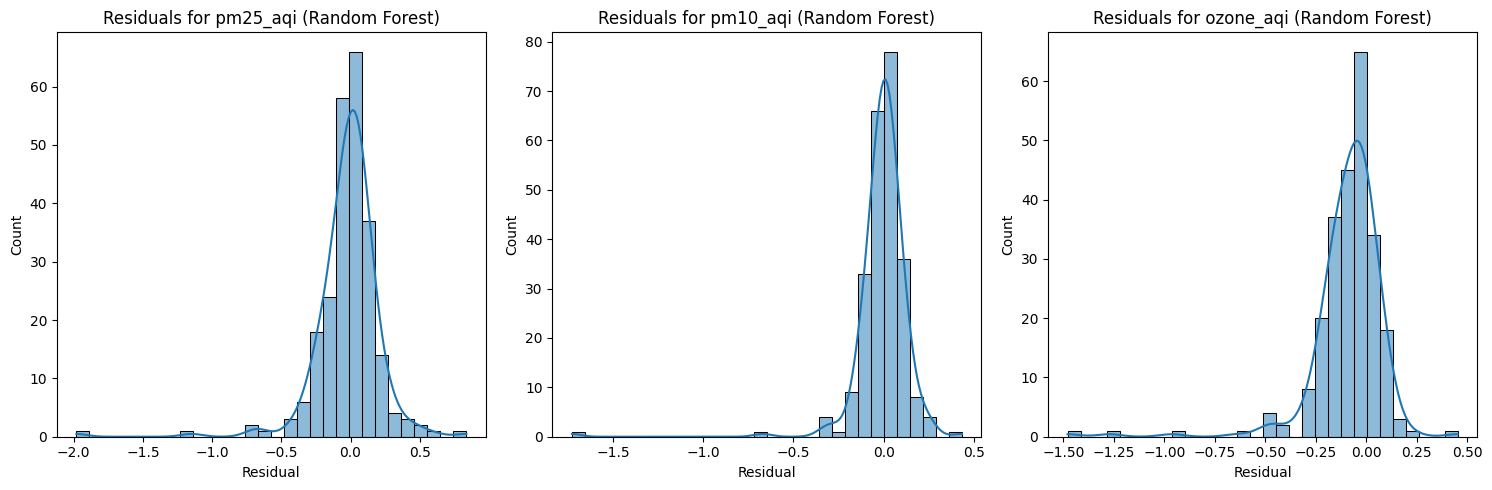

In [35]:
plt.figure(figsize=(15, 5))
for i, pollutant in enumerate(targets):
    plt.subplot(1, 3, i+1)
    residuals = y_test[pollutant].values - y_pred_rf[:, i]
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f'Residuals for {pollutant} (Random Forest)')
    plt.xlabel('Residual')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 7. Model Comparison

Compare Random Forest, XGBoost, and ARIMA using MSE, MAE, and R², with visualizations.

### Summarize model performance

In [36]:
model_results = []
for pollutant in targets:
    model_results.append({
        'Pollutant': pollutant,
        'Random Forest MSE': rf_metrics[pollutant]['MSE'],
        'Random Forest MAE': rf_metrics[pollutant]['MAE'],
        'Random Forest R²': rf_metrics[pollutant]['R²'],
        'XGBoost MSE': xgb_metrics[pollutant]['MSE'],
        'XGBoost MAE': xgb_metrics[pollutant]['MAE'],
        'XGBoost R²': xgb_metrics[pollutant]['R²'],
        'ARIMA MSE': arima_metrics[pollutant]['MSE'],
        'ARIMA MAE': arima_metrics[pollutant]['MAE'],
        'ARIMA R²': arima_metrics[pollutant]['R²']
    })
results_df = pd.DataFrame(model_results)
print("\nModel Comparison Table:")
results_df.head()


Model Comparison Table:


,Pollutant,Random Forest MSE,Random Forest MAE,Random Forest R²,XGBoost MSE,XGBoost MAE,XGBoost R²,ARIMA MSE,ARIMA MAE,ARIMA R²
0,pm25_aqi,0.055469,0.143028,0.999756,0.148052,0.240476,0.999350,158.066934,10.552618,0.305943
1,pm10_aqi,0.023718,0.080432,0.999660,0.063233,0.156935,0.999093,50.306974,5.934163,0.278554
2,ozone_aqi,0.040999,0.121298,0.999523,0.059096,0.167799,0.999313,115.098587,8.682595,-0.338979


### Plot actual vs predicted for all models

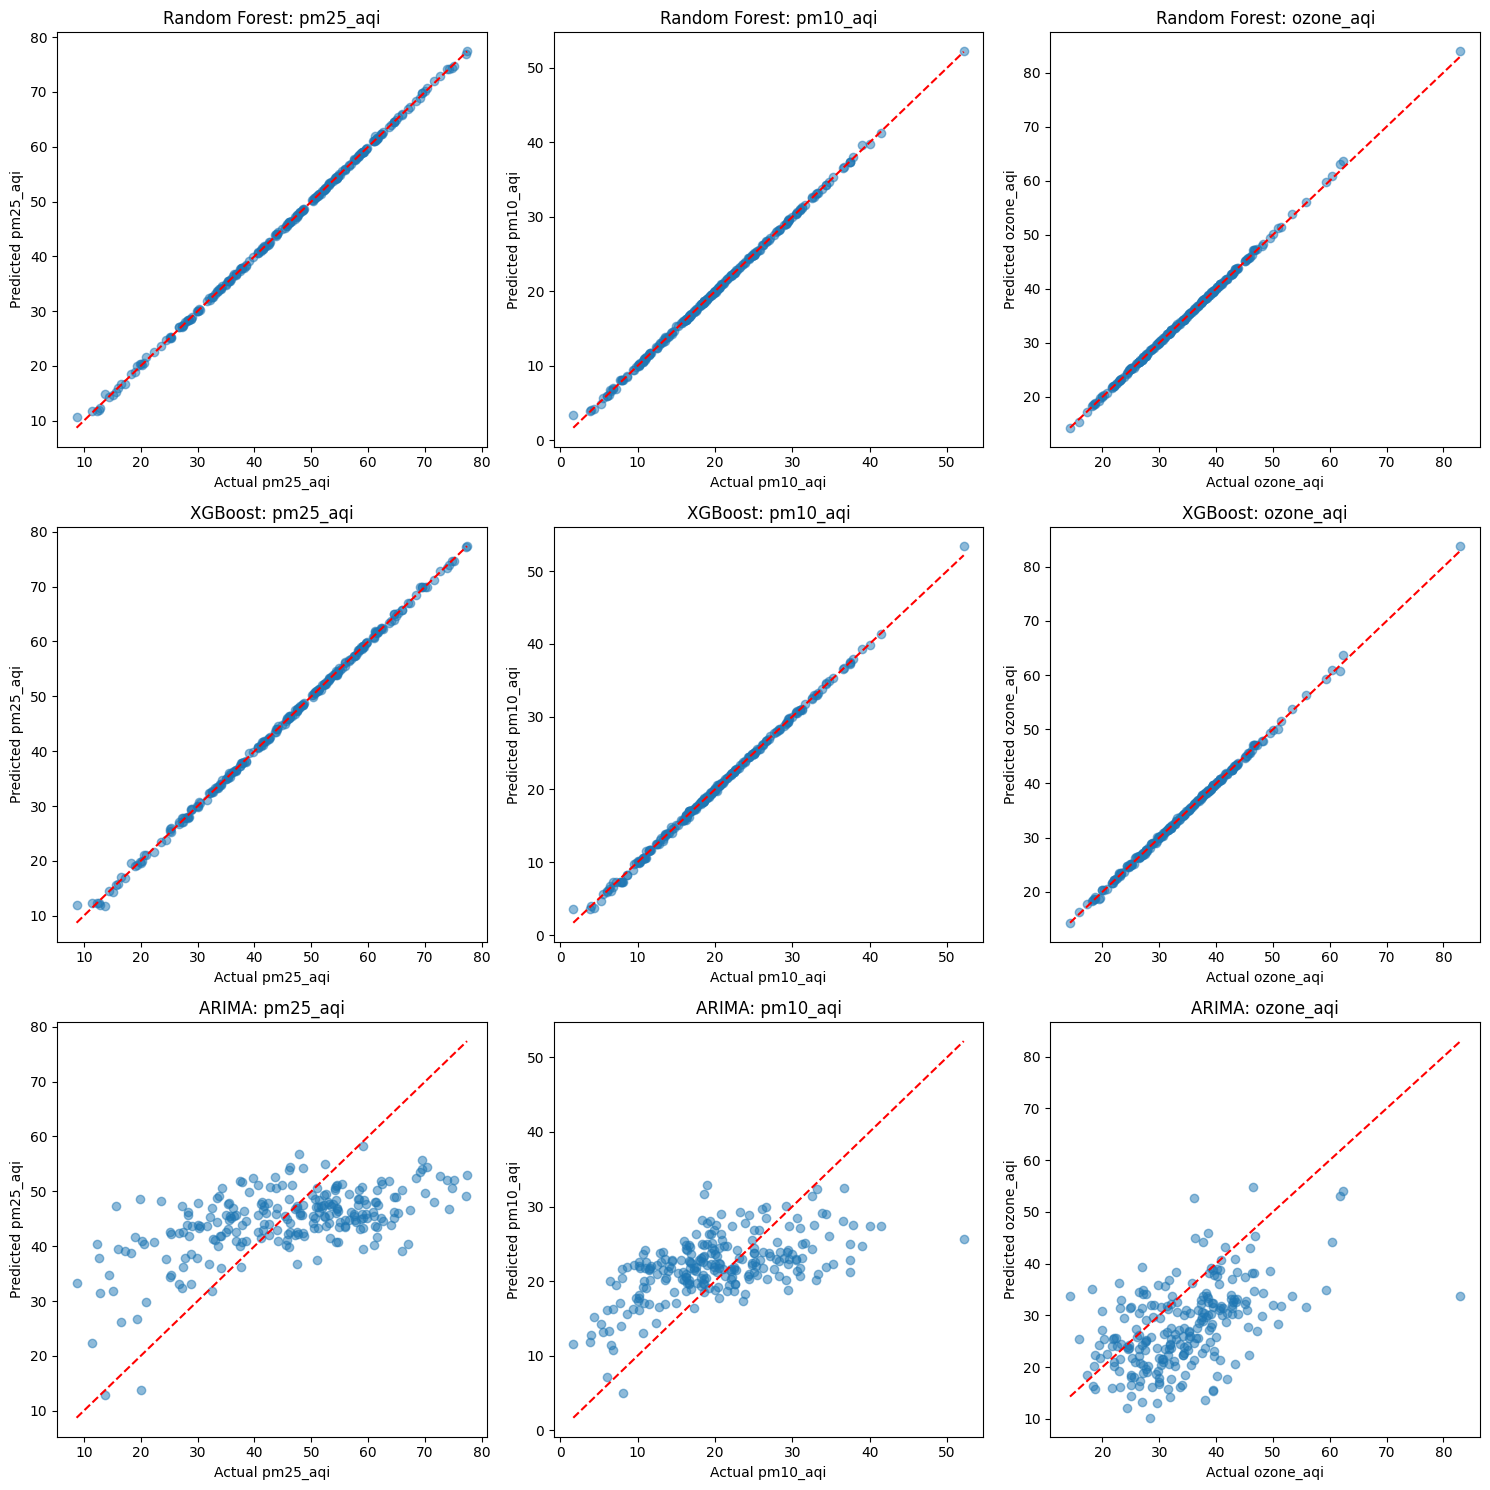

In [37]:
plt.figure(figsize=(15, 15))
for i, pollutant in enumerate(targets):
    # Random Forest
    plt.subplot(3, 3, i+1)
    plt.scatter(y_test[pollutant], y_pred_rf[:, i], alpha=0.5)
    plt.plot([y_test[pollutant].min(), y_test[pollutant].max()], [y_test[pollutant].min(), y_test[pollutant].max()], 'r--')
    plt.xlabel(f'Actual {pollutant}')
    plt.ylabel(f'Predicted {pollutant}')
    plt.title(f'Random Forest: {pollutant}')

    # XGBoost
    plt.subplot(3, 3, i+4)
    plt.scatter(y_test[pollutant], y_pred_xgb[:, i], alpha=0.5)
    plt.plot([y_test[pollutant].min(), y_test[pollutant].max()], [y_test[pollutant].min(), y_test[pollutant].max()], 'r--')
    plt.xlabel(f'Actual {pollutant}')
    plt.ylabel(f'Predicted {pollutant}')
    plt.title(f'XGBoost: {pollutant}')

    # ARIMA
    plt.subplot(3, 3, i+7)
    test_data = data[pollutant][-len(y_test):]
    plt.scatter(test_data, y_pred_arima[pollutant], alpha=0.5)
    plt.plot([test_data.min(), test_data.max()], [test_data.min(), test_data.max()], 'r--')
    plt.xlabel(f'Actual {pollutant}')
    plt.ylabel(f'Predicted {pollutant}')
    plt.title(f'ARIMA: {pollutant}')
plt.tight_layout()
plt.show()

### Bar plot for R² comparison

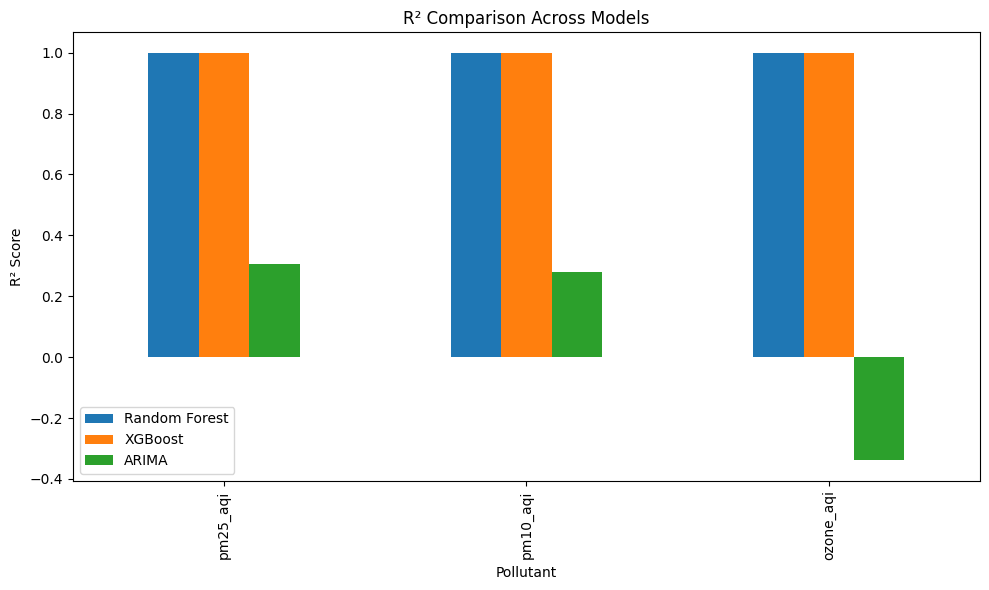

In [38]:
r2_data = {
    'Random Forest': [rf_metrics[p]['R²'] for p in targets],
    'XGBoost': [xgb_metrics[p]['R²'] for p in targets],
    'ARIMA': [arima_metrics[p]['R²'] for p in targets]
}
r2_df = pd.DataFrame(r2_data, index=targets)
r2_df.plot(kind='bar', figsize=(10, 6))
plt.title('R² Comparison Across Models')
plt.ylabel('R² Score')
plt.xlabel('Pollutant')
plt.legend()
plt.tight_layout()
plt.show()

## 8. Save Processed Data and Models

In [39]:
merged_df.to_csv('la_processed_aqi_2014_2024.csv', index=False)
import joblib
joblib.dump(rf_model, 'rf_model_multi.pkl')
joblib.dump(xgb_model, 'xgb_model_multi.pkl')
from google.colab import files
files.download('la_processed_aqi_2014_2024.csv')
files.download('rf_model_multi.pkl')
files.download('xgb_model_multi.pkl')
# Note: ARIMA models are not saved as they are typically re-fit for predictions

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>